### Relative abundance comparison SHM-seq vs 16S sequencing

Input files:<br>
names.dmp: downloaded from NCBI<br>
Bacpipeline output file SHM-Seq: QCenz_$*$Bacstdata.tsv<br>
Kraken2 data, SRA sample references: SRR9212951, SRR9213178, SRR9213335

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import Counter
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

In [21]:
#. Read in NCBI names file

ncbi_names = 'names.dmp' 

ncbi = pd.read_csv(ncbi_names, sep='\t', header=None, usecols=[0, 2, 6])
ncbi = ncbi[ncbi[6] == 'scientific name']
ncbi.columns = ['taxid', 'taxa', 'type']
ncbi.set_index('taxid', inplace=True)

# Make into dict
ncbi_dict = ncbi.to_dict('index')

ncbi_dict = {k:v['taxa'] for k,v in ncbi_dict.items()}

count = 0
for k,v in ncbi_dict.items():
    if count<2:
        print(k,v)
    count += 1

1 root
2 Bacteria


# Load QC SHM-seq

In [22]:
file_names = {'QCenz_C1':'enzymatic',
             'QCenz_D1':'enzymatic',
             'QCenz_E1':'enzymatic'}

In [23]:
# Read tsv files

path2 = ''

taxa_order = ['genus', 'family', 'order', 'class', 'phylum']

tsv_l = []
tsv_d = {}

for file in os.listdir(path2):
    if file.endswith(".tsv"):
        name = file.split('/')[-1].split('_Bac')[0]
        
        if name in list(file_names):
        
            df = pd.read_csv(os.path.join(path2, file), sep='\t')
            df.drop(columns='Unnamed: 0', inplace=True)

            df[['genus','family', 'order', 'class', 'phylum', 'domain']] = df['taxa_order'].str.split(',',expand=True)
            df['name'] = name
            df['type'] = df['name'].map(file_names)

            sum_fq = df['fastq'].sum()
            # Calculate relative abundances on genus level
            df['rel.abund'] = df['fastq'] / sum_fq *100

            df = df.loc[:,['genus', 'type', 'rel.abund']]
            df = pd.pivot(data=df, index='genus', columns='type', values='rel.abund')
            df.reset_index(inplace=True)
            
            tsv_l.append(df)
            tsv_d[name] = df
            
fc = pd.concat(tsv_l)
fc = fc.groupby('genus').mean()
fc.reset_index(inplace=True)


# External 16S

In [25]:
# Read Kraken2 report.txt 
path3 = ''

samp_sv = ['SRR9212951', 'SRR9213178', 'SRR9213335']

report_d = {}
for file in os.listdir(path3):
    if file.endswith("kraken2_report.txt"):
        name = file.split('/')[-1].split('_kraken2')[0]
        
        if name in samp_sv:

            df = pd.read_csv(os.path.join(path3, file), sep='\t', header=None, usecols=[1, 3, 4])
            df.columns = ['frags', 'level', 'taxid']
            df = df[df['level'].str.startswith('G')]
            df['genus'] = df['taxid'].replace(ncbi_dict)

            df = df[df['genus'].isin(fc['genus'].tolist())]

            # Rel.abund
            frag_sum = df['frags'].sum()
            df['rel.abund'] = df['frags'] / frag_sum *100
            report_d[name] = df

print(len(report_d))

3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's r: 0.686 pvalue: 7.488251614489639e-07


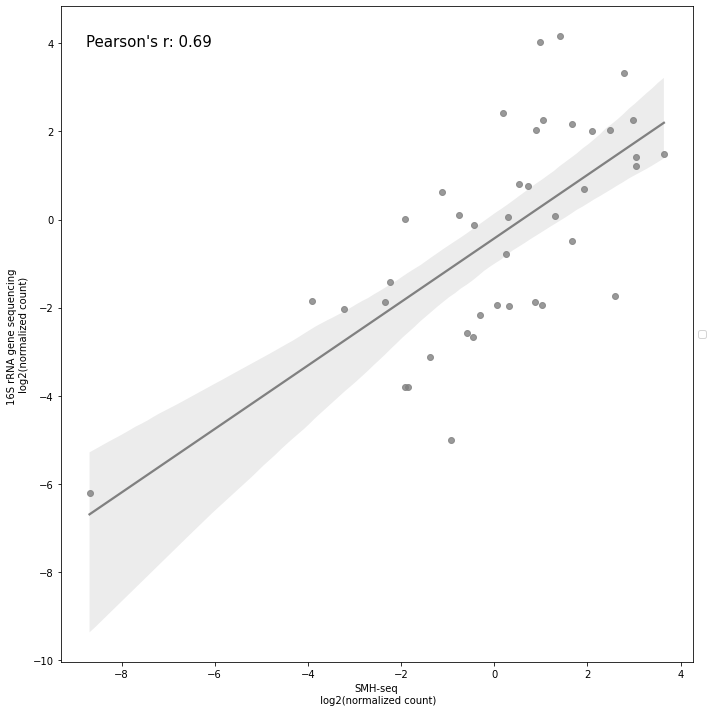

In [27]:
# Plot mean 

fr = pd.concat([report_d[samp_sv[0]], report_d[samp_sv[1]], report_d[samp_sv[2]]])
fr = fr.groupby('genus').mean()[['rel.abund']]
fr.reset_index(inplace=True)

# initialize a figure
fig = plt.figure(figsize=(10, 10))

# for a 1x1 subplot
axes = []
for row_idx in range(0,1):
    for col_idx in range(0,1):
        ax = plt.subplot2grid((1, 1), (row_idx, col_idx))

x = 'enzymatic'
y = 'rel.abund'
data = pd.concat([fc.sort_values(by='genus'), fr.sort_values(by='genus')], axis=1)
data = data.loc[:,~data.columns.duplicated()]
data.set_index('genus', inplace=True)
data = np.log2(data)
data.reset_index(inplace=True)

sns.regplot(x=x, y=y, data=data, ax=ax, x_ci='ci', color='grey', scatter_kws={'rasterized':True})#, scatter_kws={'s':1})

ax.set_xlabel('SHM-seq\n log2(normalized count)')
ax.set_ylabel('16S rRNA gene sequencing \nlog2(normalized count)')

# Pearson's r
pear, pp = pearsonr(data[x], data[y])
print("Pearson's r: " + str(round(pear, 3)) + ' pvalue: ' + str(pp))

ax.text(0.04, 0.94, "Pearson's r: " + str(round(pear, 2)), transform=ax.transAxes, fontsize=15)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
